In [186]:
import warnings
warnings.filterwarnings(action='ignore')

In [187]:
#importing packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import requests
import io
from datetime import datetime
import math

In [188]:
#download the data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

#subset Maine data & reset index
maine = df[df.state == 'Maine']

#estimate, April 1, 2020, https://www.census.gov/quickfacts/fact/table/ME/PST040221#PST040221
N = 1362359 

maine.reset_index(inplace=True,drop=True)
maine.loc[:,'recovered']= maine.sort_values(by='date')['cases'].shift(14)
maine['recovered'].fillna(0, inplace=True)
maine['susceptible'] = N - maine['recovered']- maine['deaths']
maine['infected'] = maine['cases'] - maine['recovered']

# Exploratory Data Analysis

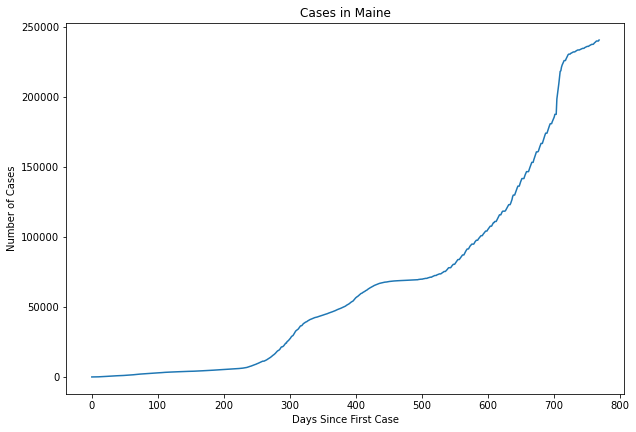

In [66]:
fig = plt.figure(figsize=(10,15))
ax1 = plt.subplot(2, 1, 1)
plt.plot(maine.index, maine.cases.values)
plt.xlabel("Days Since First Case")
plt.ylabel("Number of Cases")
plt.title("Cases in Maine")
plt.show()


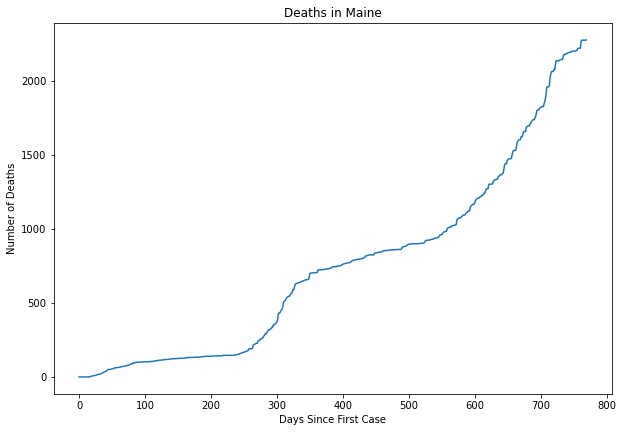

In [67]:
fig = plt.figure(figsize=(10,15))
ax1 = plt.subplot(2, 1, 1)
plt.plot(maine.index, maine.deaths.values)
plt.xlabel("Days Since First Case")
plt.ylabel("Number of Deaths")
plt.title("Deaths in Maine")
plt.show()

# Model Specification - SIR

In [206]:
### Fixed Parameters ###

#Initial Number of infected and recovered, I0 and R0
I0, R0 = 1, 0 


# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 

#number of days to compute
t = np.linspace(0, len(maine)-1, len(maine)) 


## Paramter Specification

In [69]:
### Parameters to Vary ###

#recovery rate (recovery probability within one time step)
#average illness duration of 14 days
gamma = 1./14 


In [70]:
# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Smooth R_0 transition

$$R_0(t) = \frac{R_0^{start} - R_0^{end}}{1 + e^{-k(-x+x_0)}} + R_0^{end}$$

$R_0^{start}$ and $R_0^{end}$ are the starting and ending $R_0$ values that we want to interpolate between. 

$x_0$ is the inflection point of the transition, i.e., the day that $R_0$ changes most dramatically. 

$k$ describes how fast R_0 change. Larger $k$ means faster change.

In [168]:
epochs = [0,60, 300, 467, 572]


R_0 = [2.1, 1.6, 1.3, 0.9, 1.3, 1.5]
k=0.1

#https://www.maine.gov/covid19/timeline
# 58 - march 15,2020 - declared a Civil State of Emergency
#61 -  march 31, 2020 - Stay Healthy at Home directive
#308 - January 13 - first-doses vaccinations 
#467 - May 1, 2021 - first stage of re-opening 
#567 - June 30, 2021 - state of civil emergency ends
x = [58, 61, 308, 467, 572]



def R_0_dynamic(t):
    value = None
    for i in range(len(epochs)):
        if t >= epochs[i]:
            value = logistic_R_0(t, k, x[i], R_0[i],  R_0[i+1])
    return value

def logistic_R_0(t, k, x, start, end):
    return (start - end) / (1 + np.exp(-k * (-t + x))) + end

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

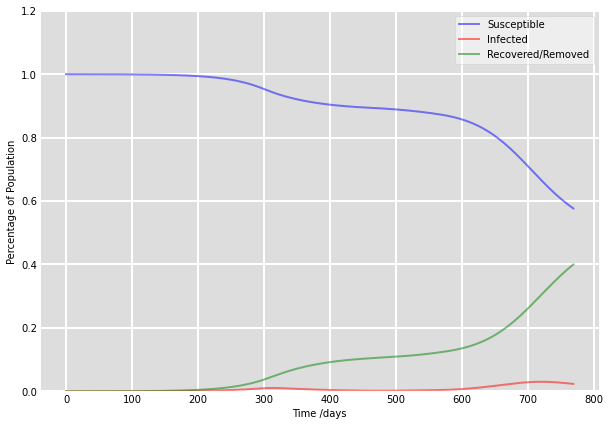

In [169]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Text(0.5, 1.0, 'Infected Cases in Maine')

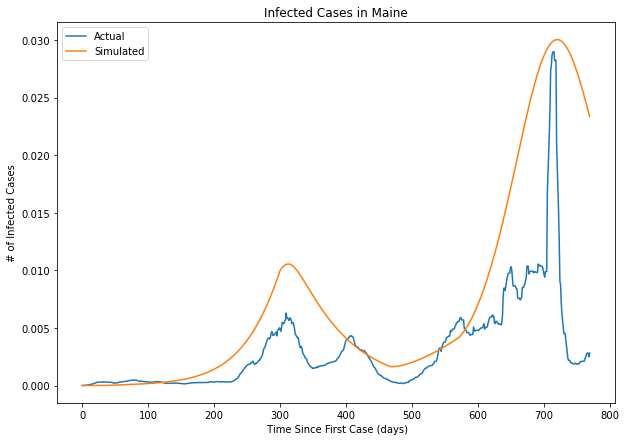

In [177]:
fig = plt.figure(figsize=(10,7))
plt.plot(maine.index,maine['infected']/N,label="Actual")
plt.plot(maine.index, I/N,label="Simulated")
plt.legend()
plt.xlabel(" Time Since First Case (days)")
plt.ylabel("# of Infected Cases")
plt.title("Infected Cases in Maine")

Text(0.5, 1.0, 'Susceptible cases in Maine')

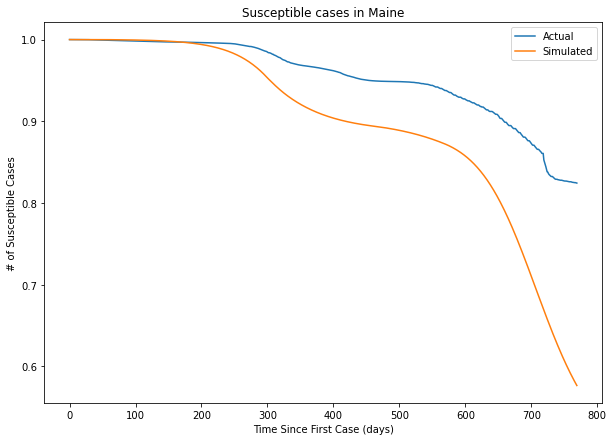

In [178]:
fig = plt.figure(figsize=(10,7))
plt.plot(maine.index,maine['susceptible']/N,label="Actual")
plt.plot(maine.index, S/N,label="Simulated")
plt.legend()
plt.xlabel("Time Since First Case (days)")
plt.ylabel("# of Susceptible Cases")
plt.title("Susceptible cases in Maine")

Text(0.5, 1.0, 'Recovered Cases in Maine')

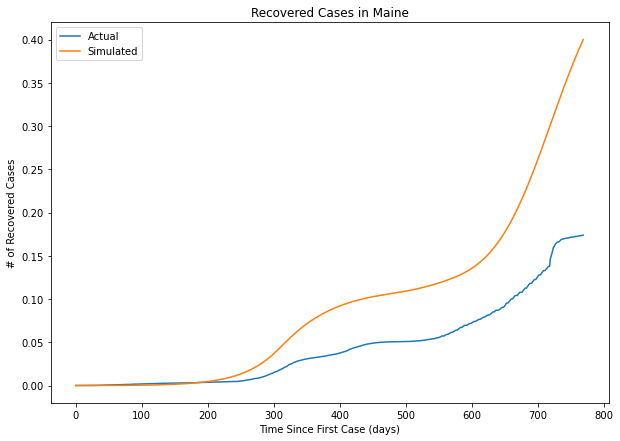

In [179]:
fig = plt.figure(figsize=(10,7))
plt.plot(maine.index,maine['recovered']/N,label="Actual")
plt.plot(maine.index, R/ N,label="Simulated")
plt.legend()
plt.xlabel("Time Since First Case (days)")
plt.ylabel("# of Recovered Cases")
plt.title("Recovered Cases in Maine")

# Calculating Errors

In [210]:
#calculate error 
def rms(actual,simulated,T):
    error=np.sqrt(np.sum(np.square(actual-simulated)/T))
    print(error)

In [219]:
def eabs(actual, simulated, T):
    error=np.sqrt(np.sum(np.abs(actual-simulated)/T))
    print(error)

In [213]:
actual = maine['infected']
simulated = I

10529.690484026036


In [221]:
rms(actual, simulated, len(t))

10529.690484026036


In [220]:
eabs(actual, simulated, len(t))

76.23255148591879
